In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from tqdm import tqdm

data_dir = '/Users/govindramesh/Horizon/SPECT-NC100' #path to parent folder with scans
scans = [] #list to hold dicom files

for root, subdirs, files in os.walk(data_dir):
    for file in files:    
        if file != '.DS_Store': #skip hidden files
            scans.append(pydicom.read_file(root + "/" + file))

for x in range(len(scans[:0])): #goes through each patient in the list
    for i in range(scans[x].pixel_array.shape[0]): #goes through each scan (91 total)
        print(x,i)
        plt.imshow(scans[x].pixel_array[i,:,:], cmap = 'gray')
        plt.show()


In [2]:
scanspa = [] #list to hold pixel arrays from dicom files
for x in range(len(scans)):
    scanspa.append(scans[x].pixel_array) 

scansmask = [] #list to hold bool/mask representation of scans
for x in range(len(scanspa)):
    scansmask.append(scanspa[x]<12800) #condition determining bool value

print(scansmask[0])

[[[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 ...

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  Tr

38


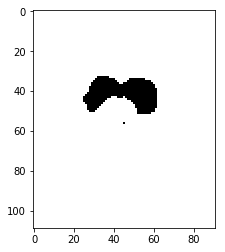

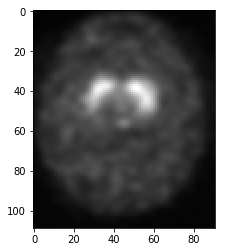

39


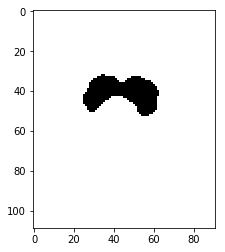

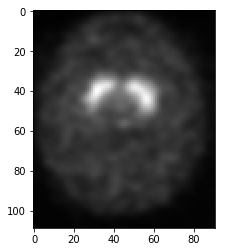

40


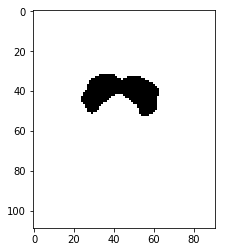

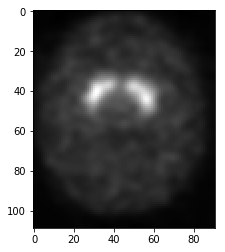

In [3]:
for x in range(38,41):
    print(x)
    plt.imshow(scansmask[0][x], cmap = 'gray')
    plt.show()
    plt.imshow(scans[0].pixel_array[x,:,:], cmap = 'gray')
    plt.show()

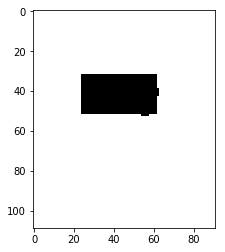

In [6]:
plt.imshow(scansmask[0][40], cmap = 'gray')
plt.show()

In [4]:
#create rectangular box around area containing mask
mask_dim_x = []
mask_dim_y = []

for a in range(len(scansmask)):
    tempx = [] #holds list of x indices for each scan for each patient
    tempy = []
    for b in range(len(scansmask[a])):    
        tempx.append(np.where(scansmask[a][b]==False)[0]) #returns x indices where false
        tempy.append(np.where(scansmask[a][b]==False)[1]) #returns y indices where false
    mask_dim_x.append(tempx)
    mask_dim_y.append(tempy)
    

print(mask_dim_x[0][40].min(), mask_dim_x[0][40].max())
print(mask_dim_y[0][40].min(), mask_dim_y[0][40].max())
scansmask[0][40][mask_dim_x[0][40].min() : mask_dim_x[0][40].max(),
                 mask_dim_y[0][40].min() : mask_dim_y[0][40].max()] = False 

32 52
24 62


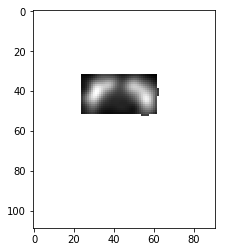

In [5]:
maskedscans = [] #list to hold scans with masks applied
maskedscans.append(np.ma.masked_where(scansmask[0][40], scans[0].pixel_array[40,:,:])) #applying bool mask to original scans

plt.imshow(maskedscans[0], cmap = 'gray')
plt.show()